# Topic 1 – Sampling and Quantization

*DSP for Audio – Offline Notebook*

**Dataset folder:** `audio_dataset/`


Run cells top-to-bottom. All files are local and offline-friendly.


## Setup


In [1]:
import os

REPO_URL = "https://github.com/fabioantonacci79/BasicDSP/tree/ab84ad3976fcb5a70e2058102dc2749e1c5298e9/notebooks/audio_dataset"
REPO_NAME = "audio_dataset"

if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}

%cd {REPO_NAME}

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from pathlib import Path
from IPython.display import Audio, display
try:
    import ipywidgets as widgets
    from IPython.display import display
    HAS_WIDGETS = True
except Exception as e:
    HAS_WIDGETS = False
    print("ipywidgets not available. We'll provide a non-interactive fallback.")

DATA_DIR = Path('audio_dataset')
SR_DEFAULT = 16000

def load_wav(path):
    sr, x = wavfile.read(path)
    # Convert to float in [-1, 1]
    if x.dtype == np.int16:
        x = x.astype(np.float32) / 32768.0
    elif x.dtype == np.int32:
        x = x.astype(np.float32) / 2147483648.0
    else:
        x = x.astype(np.float32)
    if x.ndim > 1:
        x = x.mean(axis=1)  # mono
    return sr, x

def save_wav(path, sr, x):
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1, 1)
    wavfile.write(path, sr, (x * 32767).astype(np.int16))

def play(x, sr):
    display(Audio(x, rate=sr))

def plot_time(x, sr, title='Time signal', seconds=0.05):
    n = min(len(x), int(seconds*sr))
    tt = np.arange(n)/sr
    plt.figure()
    plt.plot(tt, x[:n])
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_spectrum(x, sr, title='Magnitude spectrum'):
    N = len(x)
    w = np.hanning(N)
    X = np.fft.rfft(x*w)
    f = np.fft.rfftfreq(N, d=1/sr)
    mag = 20*np.log10(np.abs(X)+1e-12)
    plt.figure()
    plt.plot(f, mag)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.title(title)
    plt.grid(True)
    plt.xlim(0, sr/2)
    plt.show()

def delta_modulate(x_samples, Delta, x0=0.0):
    """
    Delta modulation (1-bit):
      b[n] = +1 if x[n] >= xhat[n-1] else -1
      xhat[n] = xhat[n-1] + Delta * b[n]
    Returns:
      b:   +/-1 decisions
      xhat: reconstructed staircase at sample instants
    """
    N = len(x_samples)
    b = np.zeros(N, dtype=np.int8)
    xhat = np.zeros(N, dtype=np.float64)

    prev = float(x0)
    for n in range(N):
        b[n] = 1 if x_samples[n] >= prev else -1
        prev = prev + Delta * b[n]
        xhat[n] = prev
    return b, xhat


def zoh_hold(t_samples, x_samples, t_dense):
    """
    Zero-order hold: piecewise constant reconstruction over t_dense.
    Assumes t_samples are increasing.
    """
    idx = np.searchsorted(t_samples, t_dense, side="right") - 1
    idx = np.clip(idx, 0, len(x_samples) - 1)
    return x_samples[idx]


## 1.1 Sampling and aliasing

We will:
- Generate a sine wave
- Sample it at different sampling rates
- See and *hear* aliasing


In [2]:
# Continuous-time sinusoid parameters (conceptually continuous)
f0 = 1.0          # Hz (sinusoid frequency)
A = 1.0           # amplitude
n_periods = 3     # how many periods to show
t_end = n_periods / f0

# Dense time grid to emulate "continuous" signal for plotting
t_dense = np.linspace(0, t_end, 3000, endpoint=True)
x_dense = A * np.sin(2*np.pi*f0*t_dense)

def plot_sampling(fs, phase=0.0):
    """
    fs: sampling frequency [Hz]
    phase: optional phase offset [radians] for the sinusoid
    """
    Ts = 1.0 / fs
    t_s = np.arange(0, t_end + 1e-12, Ts)   # sampling instants
    x_s = A * np.sin(2*np.pi*f0*t_s + phase)

    plt.figure(figsize=(9, 3.2))
    plt.plot(t_dense, A*np.sin(2*np.pi*f0*t_dense + phase), linewidth=2, label="continuous (reference)")
    plt.stem(t_s, x_s, basefmt=" ")
    plt.axhline(0, linewidth=1)

    plt.title(f"Sampling a 1 Hz sinusoid at fs = {fs:.2f} Hz  (Ts = {Ts:.3f} s)")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.xlim(0, t_end)
    plt.ylim(-1.2*A, 1.2*A)
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.show()

if HAS_WIDGETS:
    fs_slider = widgets.FloatSlider(
        value=8.0,
        min=1.2,
        max=40.0,
        step=0.1,
        description="fs [Hz]",
        continuous_update=True,
        readout_format=".1f",
        style={"description_width": "70px"},
        layout=widgets.Layout(width="450px")
    )

    phase_slider = widgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=2*np.pi,
        step=0.05,
        description="phase",
        continuous_update=True,
        readout_format=".2f",
        style={"description_width": "70px"},
        layout=widgets.Layout(width="450px")
    )

    ui = widgets.VBox([fs_slider, phase_slider])
    out = widgets.interactive_output(plot_sampling, {"fs": fs_slider, "phase": phase_slider})
    display(ui, out)
else:
    # Fallback: just plot a few fixed sampling frequencies
    for fs in [2.0, 3.0, 5.0, 8.0, 12.0]:
        plot_sampling(fs)


Output()

### Task A (TODO)
Downsample the reference signal to:
- 16 kHz
- 8 kHz
- 3 kHz

What do you notice when sampling is too low?


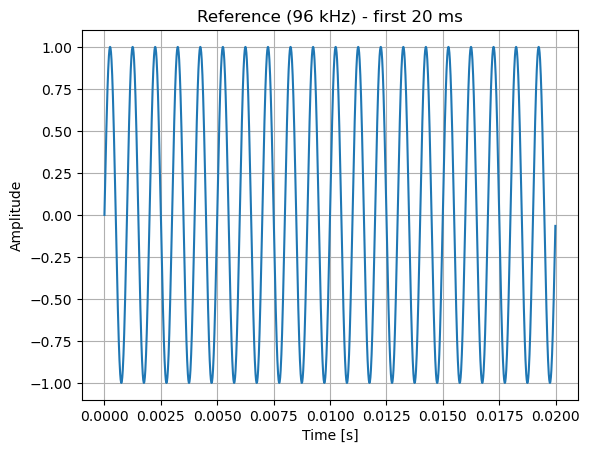

In [3]:
sr_ref = 96000
dur = 1.0
t = np.arange(int(sr_ref*dur))/sr_ref
f0 = 1000
x_ref = np.sin(2*np.pi*f0*t)
plot_time(x_ref, sr_ref, title='Reference (96 kHz) - first 20 ms', seconds=0.02)
play(x_ref, sr_ref)

sr_new = 16000 len = 16000


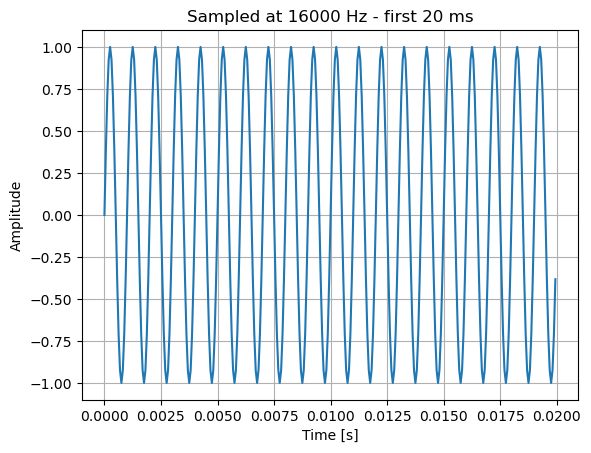

sr_new = 8000 len = 8000


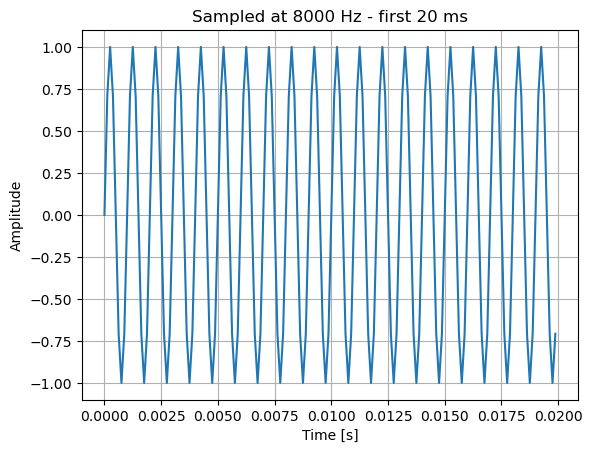

sr_new = 3000 len = 3000


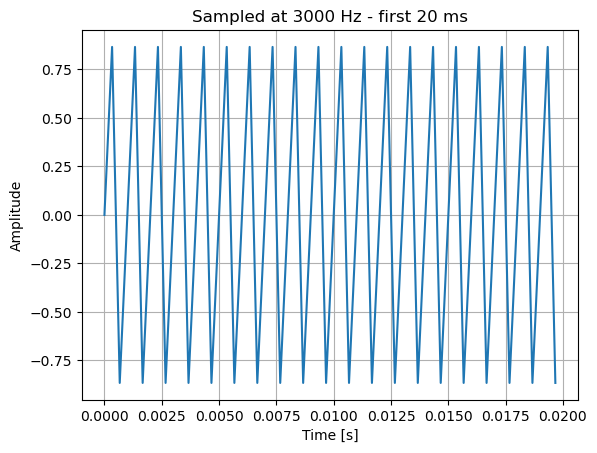

In [4]:
def decimate_simple(x, sr_old, sr_new):
    k = int(sr_old // sr_new)
    return x[::k]

for sr_new in [16000, 8000, 3000]:
    x = decimate_simple(x_ref, sr_ref, sr_new)
    print('sr_new =', sr_new, 'len =', len(x))
    plot_time(x, sr_new, title=f'Sampled at {sr_new} Hz - first 20 ms', seconds=0.02)
    play(x, sr_new)


In [2]:
sr, x = load_wav(DATA_DIR/'clean_music.wav')
for sr_new in [16000, 48000, 96000]:
    print('sr_new =', sr_new)
    play(x, sr_new)

sr_new = 16000


sr_new = 48000


sr_new = 96000


## 1.2 Quantization

Quantization maps continuous amplitudes to discrete levels (bit depth).


sr 16000 duration 6.0


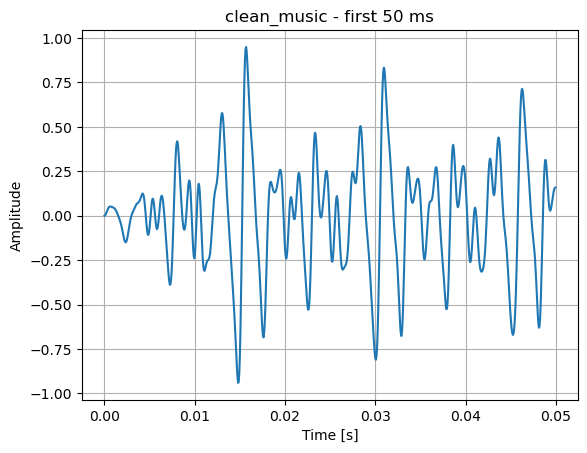

In [3]:
sr, x = load_wav(DATA_DIR/'clean_music.wav')
print('sr', sr, 'duration', len(x)/sr)
plot_time(x, sr, title='clean_music - first 50 ms', seconds=0.05)
play(x, sr)


### Task B (TODO)
Implement uniform quantization and compare:
- 4 bits
- 8 bits
- 16 bits

Listen and plot the error (quantization noise).


bits 4 error RMS 0.038431067


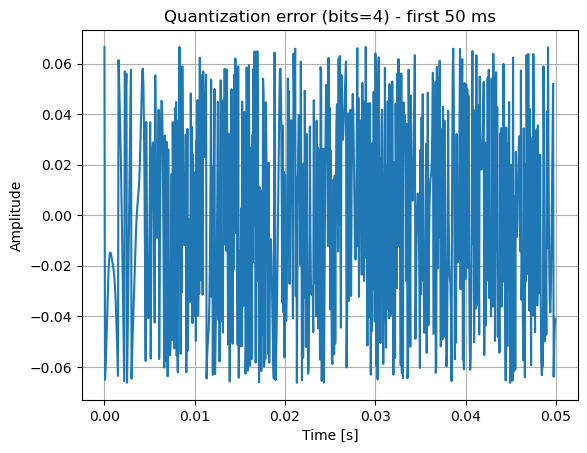

bits 8 error RMS 0.0022672408


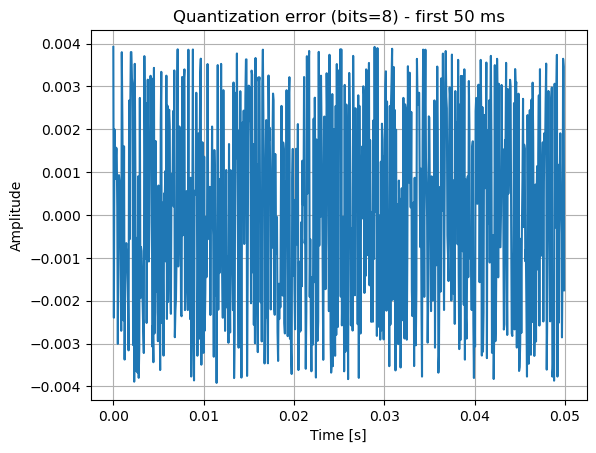

bits 16 error RMS 1.2766219e-05


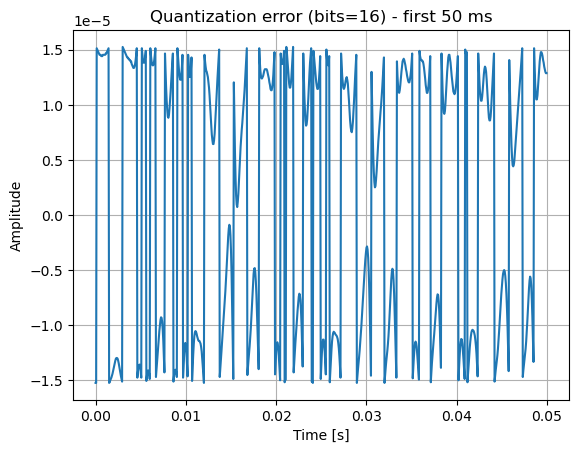

In [4]:
def quantize_uniform(x, bits):
    L = 2**bits
    delta = 2/(L-1)
    xq = np.round((x + 1)/delta)*delta - 1
    return np.clip(xq, -1, 1)

for bits in [4, 8, 16]:
    xq = quantize_uniform(x, bits)
    e = x - xq
    print('bits', bits, 'error RMS', np.sqrt(np.mean(e**2)))
    plot_time(e, sr, title=f'Quantization error (bits={bits}) - first 50 ms', seconds=0.05)
    play(xq, sr)


In [5]:
# --- Delta Modulation demo (interactive) ---

# "Virtually continuous" signal for demonstration
T_view = 2.5  # seconds shown
t_dense = np.linspace(0, T_view, 5000, endpoint=True)

def x_continuous(t):
    # Smooth test signal: sum of sinusoids (simple, audio-like)
    return 0.9*np.sin(2*np.pi*1.0*t) + 0.35*np.sin(2*np.pi*3.0*t + 0.4)

x_dense = x_continuous(t_dense)

def plot_delta_modulation(fs=200.0, Delta=0.05, show_bits=True):
    Ts = 1.0 / fs
    t_s = np.arange(0, T_view + 1e-12, Ts)
    x_s = x_continuous(t_s)

    # Delta modulation
    b, xhat = delta_modulate(x_s, Delta, x0=0.0)

    # Hold reconstruction for plotting against dense time grid
    xhat_hold = zoh_hold(t_s, xhat, t_dense)

    plt.figure(figsize=(10, 4.2))
    plt.plot(t_dense, x_dense, linewidth=2, label="continuous signal x(t)")
    plt.step(t_dense, xhat_hold, where="post", linewidth=2, label="DM reconstruction (ZOH)")

    # Show the sample points (optional, helps interpretation)
    plt.scatter(t_s, x_s, s=18, label="samples x[n]", zorder=3)

    plt.title(f"Delta Modulation (fs={fs:.1f} Hz, Δ={Delta:.3f})")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.xlim(0, T_view)
    plt.ylim(-1.6, 1.6)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right")
    plt.show()

    # Optional: show bitstream (+1/-1) as a separate compact plot
    if show_bits:
        plt.figure(figsize=(10, 1.8))
        plt.step(t_s, b, where="post")
        plt.yticks([-1, 1], ["-1", "+1"])
        plt.ylim(-1.5, 1.5)
        plt.grid(True, alpha=0.3)
        plt.title("Delta Modulator 1-bit output b[n]")
        plt.xlabel("Time [s]")
        plt.show()

        # Simple metrics for discussion
        mse = np.mean((x_s - xhat)**2)
        print(f"MSE at sample instants: {mse:.4f}")

if HAS_WIDGETS:
    fs_slider = widgets.FloatSlider(
        value=200.0, min=20.0, max=800.0, step=10.0,
        description="fs [Hz]",
        continuous_update=True,
        style={"description_width": "70px"},
        layout=widgets.Layout(width="460px")
    )
    delta_slider = widgets.FloatSlider(
        value=0.05, min=0.005, max=0.25, step=0.005,
        description="Δ",
        continuous_update=True,
        readout_format=".3f",
        style={"description_width": "70px"},
        layout=widgets.Layout(width="460px")
    )
    show_bits_toggle = widgets.Checkbox(
        value=True, description="show bitstream b[n]"
    )

    ui = widgets.VBox([fs_slider, delta_slider, show_bits_toggle])
    out = widgets.interactive_output(
        plot_delta_modulation,
        {"fs": fs_slider, "Delta": delta_slider, "show_bits": show_bits_toggle}
    )
    display(ui, out)
else:
    # Fallback: a few fixed examples
    for fs, Delta in [(50, 0.10), (200, 0.05), (400, 0.02)]:
        plot_delta_modulation(fs=fs, Delta=Delta, show_bits=False)


Output()

## Reflection
- What is aliasing and when does it happen?
- How does bit depth affect perceived quality?
